## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy


In [8]:
from scipy import stats
import numpy as np
import seaborn as sns
import pandas as pd

column_headers = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', header=None, names=column_headers, na_values="?")
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [12]:
df = df.replace({'y': 1, 'n': -1})
df_nonan = df.fillna(0)
df_nonan.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0
1,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,0.0
2,democrat,0.0,1.0,1.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0
3,democrat,-1.0,1.0,1.0,-1.0,0.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,-1.0,1.0
4,democrat,1.0,1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,1.0,0.0,1.0,1.0,1.0,1.0


In [16]:
rep = df_nonan[df_nonan['party']=='republican']
dem = df_nonan[df_nonan['party']=='democrat']
rep.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,1.0,0.0,1.0,1.0,1.0,-1.0,1.0
1,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,0.0
7,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,0.0,1.0
8,republican,-1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1.0,1.0,-1.0,1.0
10,republican,-1.0,1.0,-1.0,1.0,1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0.0,0.0,1.0,1.0,-1.0,-1.0


In [0]:
def confidence_interval(rep, confidence=0.95):
  data = np.array(rep)
  mean = np.mean(rep)
  n = len(rep)

  stderr = stats.sem(rep)
  moe = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean - moe, mean, mean + moe)

In [21]:
##Confidence interval for immigration column for republicans
confidence_interval(rep['immigration'])

(-0.03731913888511405, 0.1130952380952381, 0.26350961507559023)

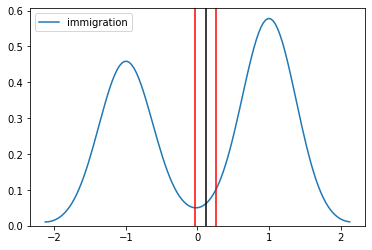

In [34]:
import seaborn as sns
from matplotlib import pyplot as plt

sns.kdeplot(rep['immigration'])
CI = confidence_interval(rep['immigration'])
plt.axvline(x=CI[0], color='red')
plt.axvline(x=CI[2], color='red')
plt.axvline(x=CI[1], color='k');


**Interpretation of CI:**

My interpretation is that you can see here that between both parties, they are most likely to vote "Yes" on the immigration bill. This is because the CI is more toward the right than the left(right is for yes, left is for no)

## Chi-Squared tests

In [45]:
# Im going to use the Loan data we used back in the make features class
!wget https://resources.lendingclub.com/LoanStats_2018Q4.csv.zip

--2019-11-05 21:26:52--  https://resources.lendingclub.com/LoanStats_2018Q4.csv.zip
Resolving resources.lendingclub.com (resources.lendingclub.com)... 64.48.1.20
Connecting to resources.lendingclub.com (resources.lendingclub.com)|64.48.1.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘LoanStats_2018Q4.csv.zip’

LoanStats_2018Q4.cs     [                 <=>]  21.67M   843KB/s    in 27s     

2019-11-05 21:27:19 (833 KB/s) - ‘LoanStats_2018Q4.csv.zip’ saved [22727580]



In [46]:
!unzip LoanStats_2018Q4.csv.zip

Archive:  LoanStats_2018Q4.csv.zip
  inflating: LoanStats_2018Q4.csv    


In [0]:

import pandas as pd


df = pd.read_csv('LoanStats_2018Q4.csv', header=1, skipfooter=2, engine='python')
print(df.shape)
df.head()

In [0]:
df['verification_status'].value_counts()

In [53]:
contingency_table = pd.crosstab(df['loan_status'], df['verification_status'], margins=True)

contingency_table

verification_status,Not Verified,Source Verified,Verified,All
loan_status,,,,
Charged Off,1114,1134,615,2863
Current,48100,40237,16415,104752
Default,93,78,46,217
Fully Paid,7495,6538,2567,16600
In Grace Period,297,292,166,755
Late (16-30 days),257,270,141,668
Late (31-120 days),994,1017,546,2557
All,58350,49566,20496,128412


In [54]:
## Chi-squared in one line, plus other info cause I was curious(knew there were more DOF than usual)
chi_squared, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 


Chi-Squared: 217.93399457978327
P-value: 1.0361154217636018e-34
Degrees of Freedom: 21


In [65]:
## Chi-squared by hand:
row_sums = contingency_table.iloc[0:7, 3]
col_sums = contingency_table.iloc[7, 0:3]
print(row_sums)
print(col_sums)

loan_status
Charged Off             2863
Current               104752
Default                  217
Fully Paid             16600
In Grace Period          755
Late (16-30 days)        668
Late (31-120 days)      2557
Name: All, dtype: int64
verification_status
Not Verified       58350
Source Verified    49566
Verified           20496
Name: All, dtype: int64


In [59]:
total = contingency_table.loc['All', 'All']
total

128412

In [66]:
expected = []
for i in range(len(row_sums)):
  expected_row = []
  for column in col_sums:
    expected_val = column*row_sums[i]/total
    expected_row.append(expected_val)
  expected.append(expected_row)
  
expected = np.array(expected)
print(expected)

[[1.30093800e+03 1.10509499e+03 4.56967012e+02]
 [4.75989721e+04 4.04334301e+04 1.67195978e+04]
 [9.86041024e+01 8.37602561e+01 3.46356415e+01]
 [7.54298664e+03 6.40746659e+03 2.64954677e+03]
 [3.43069573e+02 2.91423932e+02 1.20506495e+02]
 [3.03537053e+02 2.57842632e+02 1.06620316e+02]
 [1.16189258e+03 9.86981450e+02 4.08125970e+02]]


In [67]:
observed = pd.crosstab(df['loan_status'], df['verification_status']).values
print(expected.shape)
print(observed.shape)

(7, 3)
(7, 3)


In [68]:
chi_squared = ((observed - expected)**2/(expected)).sum() 
print(f"Chi-Squared: {chi_squared}")

Chi-Squared: 217.93399457978327


In [0]:
# It matches!! awesome, think im getting the hang of it, still need to wrap my head around certain aspects though

## Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)